In [1]:
import rebound
import numpy as np
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
from celmech.secular import LaplaceLagrangeSystem
import matplotlib.pyplot as plt
import reboundx
from reboundx import constants

# Laplace-Lagrange Theory with General Relativistic correction
This notebook shows how to include a correction for genral relativistic precession when modeling a system's secular evolution with the `LaplaceLagranceSystem` class. To lowest order in eccentricity, periapse precession due to general relativistic effects is given by (e.g., [Nobili & Roxburgh, 1986](https://ui.adsabs.harvard.edu/abs/1986IAUS..114..105N/abstract)):
$$
\dot \varpi_\mathrm{GR} \approx \frac{3 GM_*}{c^2a}n~.
$$
This can be written in terms of `celmech`'s default canonical variables as $\dot \varpi_\mathrm{GR} = \frac{3 G^4M^4 \mu^5}{c^2 \Lambda^5}$.

The `LaplaceLagrangeSystem.add_general_relativity_correction` accounts for this extra precession by making the appropriate modifications to the `LaplaceLagrangeSystem.eccentricity_matrix`. This is illustrated in the short example below.

First, we'll set up a `rebound` simulation and add general relativistic precession through `reboundx`'s `gr_potential` effect:

In [2]:
# Set up a rebound simulation
sim = rebound.Simulation()
sim.add(m=1)
sim.add(m=1e-5, a=0.1, e=0.001)
sim.add(m=1e-5, a=0.2, e=0.001, pomega=0.5*np.pi)
sim.move_to_com()
sim.integrator = 'whfast'
sim.dt = sim.particles[1].P / 25.

# Use reboundx to add GR. 
# This example uses the simplest implementation, `gr_potential`.
rebx = reboundx.Extras(sim)
gr = rebx.load_force("gr_potential")
rebx.add_force(gr)
gr.params["c"] = constants.C

Now, we'll integrate the simulation and save it to a `Simulationarchive` file.

In [3]:

Tfin = 1e5
sim.save_to_file("sim_with_gr.sa",interval=Tfin/256,delete_file=True)
sim.integrate(Tfin)
sa = rebound.Simulationarchive("sim_with_gr.sa")
nbody_soln = get_simarchive_integration_results(sa) # store N-body results

/Users/hadden/miniconda3/envs/celmech/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


We can use the initial simulation snapshot to set up a `LaplaceLagrangeSystem` object

In [4]:

sim0 = sa[0] # get initial simulation
ll_sys = LaplaceLagrangeSystem.from_Simulation(sim0) # set up analytic Laplace-Lagrange solution
soln_no_GR  = ll_sys.secular_eccentricity_solution(nbody_soln['time']) # calculate analytic solution 

ll_sys.eccentricity_matrix # show the eccentricity matrix

⎡                                                       2            2         ↪
⎢-2⋅C_{(0,0,0,0,0,0)}_{1,2})__{(0,0,1,0),(0,0)}(\alpha⋅G ⋅M₂⋅m₁⋅m₂⋅μ₂    -C_{( ↪
⎢──────────────────────────────────────────────────────────────────────  ───── ↪
⎢                                     2                                        ↪
⎢                                Λ₁⋅Λ₂                                         ↪
⎢                                                                              ↪
⎢                                                      2            2          ↪
⎢-C_{(0,0,1,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G ⋅M₂⋅m₁⋅m₂⋅μ₂     -2⋅C_ ↪
⎢─────────────────────────────────────────────────────────────────────   ───── ↪
⎢                              ____   5/2                                      ↪
⎣                            ╲╱ Λ₁ ⋅Λ₂                                         ↪

↪                                                  2            2  ⎤
↪ 0,0,1,-1,0,0)}_{1,2})__{(0,0,0,0),(0,

Now we will modify our analytic solution by using the `LaplaceLagrangeSystem.add_general_relativity_correction` method:

In [5]:
# Compute secular solution with GR correction
ll_sys.add_general_relativity_correction(constants.C) # add GR correction
soln_with_GR  = ll_sys.secular_eccentricity_solution(nbody_soln['time']) # compute a new analytic solution 

# show the new, modified eccentricity matrix
ll_sys.eccentricity_matrix # show the eccentricity matrix

⎡                                                        2            2      4 ↪
⎢  2⋅C_{(0,0,0,0,0,0)}_{1,2})__{(0,0,1,0),(0,0)}(\alpha⋅G ⋅M₂⋅m₁⋅m₂⋅μ₂    3⋅G  ↪
⎢- ──────────────────────────────────────────────────────────────────── - ──── ↪
⎢                                      2                                       ↪
⎢                                 Λ₁⋅Λ₂                                      Λ ↪
⎢                                                                              ↪
⎢                                                              2            2  ↪
⎢        -C_{(0,0,1,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G ⋅M₂⋅m₁⋅m₂⋅μ₂   ↪
⎢        ───────────────────────────────────────────────────────────────────── ↪
⎢                                      ____   5/2                              ↪
⎣                                    ╲╱ Λ₁ ⋅Λ₂                                 ↪

↪    4   5                                                                2    ↪
↪ ⋅M₁ ⋅μ₁           -C_{(0,

Below, we plot a comparison between the direct N-body integration and our analytic solutions with and without a correction for general relativistic precession:

Text(0.5, 0, 'Time')

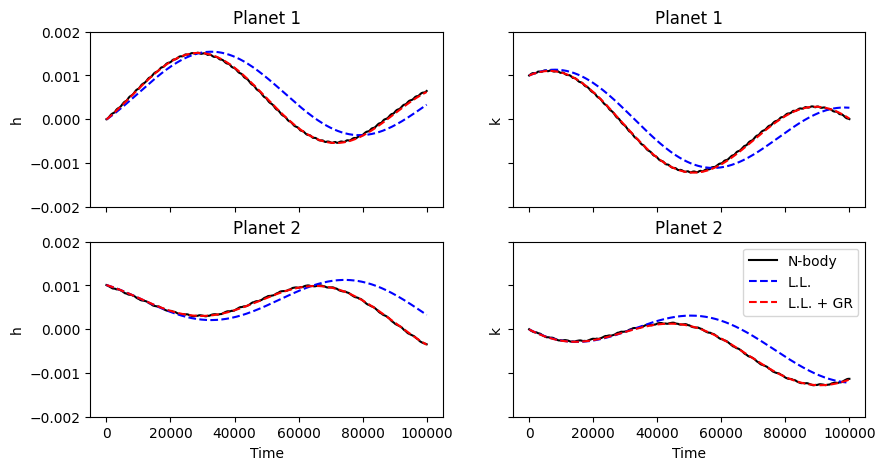

In [6]:
fig,ax = plt.subplots(2,2,sharex = True,figsize=(10,5),sharey = True)


nbody_soln['h'] = nbody_soln['e'] * np.sin(nbody_soln['pomega'])
nbody_soln['k'] = nbody_soln['e'] * np.cos(nbody_soln['pomega'])

lbls = ("N-body","L.L.","L.L. + GR")
styles = ('k-','b--','r--')
solns = (nbody_soln,soln_no_GR,soln_with_GR)
for j,var in enumerate(('h','k')):
    ax[0,j].set_ylabel(var)
    ax[1,j].set_ylabel(var)
    for i in range(2):
        for lbl,style,soln in zip(lbls,styles,solns):
            ax[i,j].plot(soln['time'],soln[var][i],style,label=lbl)
            ax[i,j].set_title(f"Planet {i+1}")
            
ax[0,0].set_ylim(-0.002,0.002)
ax[1,1].legend()
ax[1,1].set_xlabel("Time")
ax[1,0].set_xlabel("Time")